In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('dataset/GooglePlay_pion.csv')

In [3]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
data.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
6685,BR Chat Bot,SOCIAL,1.9,16,2.6M,"1,000+",Free,0,Everyone,Social,"June 30, 2016",1.0,4.0 and up
1315,Map My Ride GPS Cycling Riding,HEALTH_AND_FITNESS,4.5,106547,54M,"1,000,000+",Free,0,Everyone,Health & Fitness,"July 27, 2018",18.7.1,5.0 and up
4139,F Length Sim (no Ads),PHOTOGRAPHY,NaN,0,1.7M,10+,Paid,$2.00,Everyone,Photography,"April 29, 2018",1.0,4.0.3 and up
5410,Virtual lover,FAMILY,4.6,45771,28M,"1,000,000+",Free,0,Mature 17+,Entertainment,"June 8, 2018",1.39,4.1 and up
7457,Calvin Klein – US Store,SHOPPING,4.7,221,9.5M,"50,000+",Free,0,Teen,Shopping,"August 1, 2017",3.6.0,4.1 and up


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8999 non-null   object 
 1   Category        8999 non-null   object 
 2   Rating          7957 non-null   float64
 3   Reviews         8999 non-null   int64  
 4   Size            8999 non-null   object 
 5   Installs        8999 non-null   object 
 6   Type            8999 non-null   object 
 7   Price           8999 non-null   object 
 8   Content Rating  8999 non-null   object 
 9   Genres          8999 non-null   object 
 10  Last Updated    8999 non-null   object 
 11  Current Ver     8992 non-null   object 
 12  Android Ver     8997 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 914.1+ KB


In [6]:
# value counts for fast browsing on vscode
vc_category = data['Category'].value_counts()
vc_genres = data['Genres'].value_counts()
vc_current_ver = data['Current Ver'].value_counts()
vc_android_ver = data['Android Ver'].value_counts()

## Quick first observations
* _columnName {importance}{valuetype}{comment/action plan}_
### Columns: 
* app{-1}{__categorical__}{not needed to make a prediction, unless we are trying to figure out a good name for a highly installable app. Candidate for removal.}
* category{4}{__categorical__}{Encode it}
* rating {4}{__numerical__}{has nan values, but setting the value to 0 or any number might yield to wrong information. We could either ignore it (remove those that are nan), or predict some of its values}
* size{1}{__categorical__}{candidate to be converted to numerical value, although, it doesn't feel as if it could give a lot of information.}
* installs{__target feature__}
* type {-1}{__categorical__}{can be infered from actual price column, candidate for removal}
* price {5}{__categorical__}{needs to be converted to numeric value}
* content rating {1}{__categorical__}{Encode it}
* genres {2}{__categorical__}{this seems to have a mixed of base categories and subcategories, for instance action is a category (meaning it can come alone) but "action & adventure" always comes along with some other category, explore more to define a strategy, first thoughts either remove the column (since we have category) or create categories from "subcategories" like "action & adventure" or "creativity"}
* Last Updated {2}{__categorical__}{actually a date value, convert to date. But not sure about its impact}
* Current ver {0}{__numerical__}{"varies with device" is very high, and it normally shouldn't affect the prediction, as the nomenclature might change from developer to developer, candidate for removal}
* Android ver {1}{__categorical__}{actually cound be treated as numerical, but according to [this](https://developer.android.com/guide/topics/manifest/uses-sdk-element) some values also convey extra information whether it is wearable or not, I am going to assume that _we are not interested on wearables_, => I think it should be safe to remove them. There are some others that show a range of android versions, => I think it should be safe to remove them. "varies with device" contributes a lot of counts, I think it should be safe to remove them. And, finally "normalize" the data by versions. This can also lead to make an analysis were it is treated as a number or as a category hence using hot encoding}

### Data prep: 1st round 

In [7]:
# working dataset
pion = data.copy()

# drop unnecessary columns
pion.drop(["App", "Type", "Current Ver"], axis=1, inplace=True)

#convert to datetime
pion['Last Updated'] = pd.to_datetime(pion['Last Updated'])

In [8]:
# For now I will drop this one
pion.drop(["Last Updated"], axis=1, inplace=True)

#### Column: Android Ver

In [9]:
# drop wearables
pion.drop(pion[pion['Android Ver'].str.contains('W', na=False)].index, inplace=True)
# drop 'Varies with device'
pion.drop(pion[pion['Android Ver'].str.contains('Varies', na=False)].index, inplace=True)
# drop ranges of versions
pion.drop(pion[pion['Android Ver'].str.contains('-', na=False)].index, inplace=True)
# remove 'and up'
pion['Android Ver'] = pion['Android Ver'].str.replace('and up', '')
# approximate versions
pion['Android Ver'] = pion['Android Ver'].str.replace('2.0.1', '2.0')
pion['Android Ver'] = pion['Android Ver'].str.replace('2.3.3', '2.3')
pion['Android Ver'] = pion['Android Ver'].str.replace('4.0.3', '4.0')
# convert to number
pion['Android Ver'] = pd.to_numeric(pion['Android Ver'])

#### Column: Price

In [11]:
pion['Price'] = pion['Price'].replace('[\$,]', '', regex=True).astype(float)

#### Column: Size

In [12]:
'''Convert to megabytes'''
def to_megas(x):
    if x.find('M')>=0 :
        return float(x.replace('M', ''))
    if x.find('k')>=0 :
        temp = float(x.replace('k', ''))/1000
        return temp
    return x


In [13]:
# Convert to mb
pion['Size'] = pion['Size'].apply(to_megas)
# empties 'varies with device'
pion['Size'] = pion['Size'].replace('[Varies with device]', '', regex=True)
# Transforms to numeric
pion['Size'] = pd.to_numeric(pion['Size'])

In [14]:
# Strategy 1
median = pion['Size'].median()
pion['Size'].fillna(median, inplace=True)

#### Column: Installs
[source](https://stackoverflow.com/questions/11487470/number-of-downloads-in-google-play)

In [15]:
# - since the "Installs" is given in occluded format, convert number of install to 1:4 point to the next level.
# assume 0+ exists and is equals to 1+
dic_installs_to_val = {
'0+': 1-0.2*(1 - 5),
'1+': 1-0.2*(1 - 5),
'5+': 5-0.2*(5 - 10),
'10+': 10-0.2*(10 - 50),
'50+': 50-0.2*(50 - 100),
'100+': 100-0.2*(100 - 500),
'500+': 500-0.2*(500 - 1000),
'1,000+': 1000-0.2*(1000 - 5000),
'5,000+': 5000-0.2*(5000 - 10000),
'10,000+': 10000-0.2*(10000 - 50000),
'50,000+': 50000-0.2*(50000 - 100000),
'100,000+': 100000-0.2*(100000 - 500000),
'500,000+': 500000-0.2*(500000 - 1000000),
'1,000,000+': 1000000-0.2*(1000000 - 5000000),
'5,000,000+': 5000000-0.2*(5000000 - 10000000),
'10,000,000+': 10000000-0.2*(10000000 - 50000000),
'50,000,000+': 50000000-0.2*(50000000 - 100000000),
'100,000,000+': 100000000-0.2*(100000000 - 500000000),
'500,000,000+': 500000000-0.2*(500000000 - 1000000000),
'1,000,000,000+': 1000000000-0.2*(1000000000 - 5000000000)
}

In [16]:
pion['Installs'] = pion['Installs'].apply(lambda x: dic_installs_to_val[x])

In [17]:
pion.describe()

,Rating,Reviews,Size,Installs,Price,Android Ver
count,6721.000000,7.728000e+03,7728.000000,7.728000e+03,7728.000000,7726.000000
mean,4.188290,3.194067e+05,21.398500,1.414453e+07,1.199357,3.894978
std,0.530816,1.907432e+06,22.389187,7.925794e+07,17.575407,0.821255
min,1.000000,0.000000e+00,0.008500,1.800000e+00,0.000000,1.000000
25%,4.000000,3.800000e+01,5.300000,1.800000e+03,0.000000,4.000000
50%,4.300000,1.563500e+03,13.000000,1.800000e+05,0.000000,4.100000
75%,4.500000,3.887275e+04,29.000000,1.800000e+06,0.000000,4.200000
max,5.000000,4.489389e+07,100.000000,1.800000e+09,400.000000,8.000000


In [18]:
corr_matrix = pion.corr()

In [19]:
corr_matrix

,Rating,Reviews,Size,Installs,Price,Android Ver
Rating,1.000000,0.089209,0.093160,0.064216,-0.025286,0.044334
Reviews,0.089209,1.000000,0.243906,0.644826,-0.011367,0.022584
Size,0.093160,0.243906,1.000000,0.164730,-0.024333,0.139881
Installs,0.064216,0.644826,0.164730,1.000000,-0.012148,0.035412
Price,-0.025286,-0.011367,-0.024333,-0.012148,1.000000,0.008881
Android Ver,0.044334,0.022584,0.139881,0.035412,0.008881,1.000000


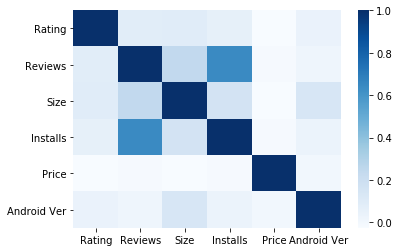

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# correlation between installs and reviews
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix,cmap='Blues',annot=False) 

In [21]:
corr_matrix["Installs"].sort_values(ascending=False)

Installs       1.000000
Reviews        0.644826
Size           0.164730
Rating         0.064216
Android Ver    0.035412
Price         -0.012148
Name: Installs, dtype: float64

###  Prepare for machine learning

In [22]:
pion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7728 entries, 0 to 8998
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        7728 non-null   object 
 1   Rating          6721 non-null   float64
 2   Reviews         7728 non-null   int64  
 3   Size            7728 non-null   float64
 4   Installs        7728 non-null   float64
 5   Price           7728 non-null   float64
 6   Content Rating  7728 non-null   object 
 7   Genres          7728 non-null   object 
 8   Android Ver     7726 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 603.8+ KB


In [23]:
pion_x_pre = pion.drop("Installs", axis=1)
pion_y = pion["Installs"].copy() # labels

In [24]:
pion_x_num = pion_x_pre.drop(["Category", "Content Rating"], axis=1)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# num_pipeline = Pipeline([
        # ('std_scaler', StandardScaler()),
    # ])

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(pion_x_num)
cat_attribs = ["Category", "Content Rating"]

# full_pipeline = ColumnTransformer([
#         ("num", num_pipeline, num_attribs),
#         ("cat", OneHotEncoder(), cat_attribs),
#     ])

full_pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(), cat_attribs),
])

In [27]:
pion_prepared = full_pipeline.fit_transform(pion_x_pre)

In [28]:
pion_prepared.shape

(7728, 39)

In [29]:
# - split the data file into 8:2 Train:Validation.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pion_prepared, pion_y, test_size=0.2, random_state=42)

## ML Model


In [30]:
import xgboost
from sklearn.metrics import mean_squared_log_error, mean_squared_error


In [31]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

In [32]:
val_error = mean_squared_error(y_test, y_pred)
print("Validation:", val_error)

Validation: 6936268422339216.0
